In [2]:
json_file='/projectnb/measures/datasets/Grids/FILTERED/json/GLANCE_V01_AS_PROJ_TILE_FILTERED.geojson'


In [3]:
import geopandas as gpd
from pathlib import Path

json_path = Path(json_file)
if not json_path.exists():
    raise FileNotFoundError(f"Missing GeoJSON: {json_path}")

tiles = gpd.read_file(json_path)
print(f"Tiles loaded: {len(tiles):,}")
print(f"CRS: {tiles.crs}")
print("Total bounds (xmin, ymin, xmax, ymax):", tiles.total_bounds)

sample_bounds = tiles.geometry.bounds.head().rename(columns={"minx": "xmin", "miny": "ymin", "maxx": "xmax", "maxy": "ymax"})
print("\nSample tile bounds:")
print(sample_bounds)


Tiles loaded: 2,153
CRS: EPSG:4326
Total bounds (xmin, ymin, xmax, ymax): [-4805840. -4559265.  5244160.  4590735.]

Sample tile bounds:
        xmin       ymin       xmax       ymax
0  2094160.0  4440735.0  2244160.0  4590735.0
1  2244160.0  4440735.0  2394160.0  4590735.0
2  2694160.0  4440735.0  2844160.0  4590735.0
3  2844160.0  4440735.0  2994160.0  4590735.0
4 -1055840.0  4290735.0  -905840.0  4440735.0


In [4]:
tiles


,horizontal,vertical,land,tileID,geometry
0,46.0,4.0,1,h46v4,"POLYGON ((2244160 4440735, 2094160 4440735, 20..."
1,47.0,4.0,0,h47v4,"POLYGON ((2394160 4440735, 2244160 4440735, 22..."
2,50.0,4.0,1,h50v4,"POLYGON ((2844160 4440735, 2694160 4440735, 26..."
3,51.0,4.0,1,h51v4,"POLYGON ((2994160 4440735, 2844160 4440735, 28..."
4,25.0,5.0,1,h25v5,"POLYGON ((-905840 4290735, -1055840 4290735, -..."
...,...,...,...,...,...
2148,11.0,63.0,0,h11v63,"POLYGON ((-3005840 -4409265, -3155840 -4409265..."
2149,32.0,63.0,1,h32v63,"POLYGON ((144160 -4409265, -5840 -4409265, -58..."
2150,33.0,63.0,1,h33v63,"POLYGON ((294160 -4409265, 144160 -4409265, 14..."
2151,10.0,64.0,0,h10v64,"POLYGON ((-3155840 -4559265, -3305840 -4559265..."


In [6]:
import os
import rioxarray as rxr
import xarray as xr
year = 2016
folder_glance = "/projectnb/measures/products/SA/v001/DAAC/LC/"
folder_mapbiomas = "/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/"
# outdir = f"/projectnb/modislc/users/chishan/data/forest_comparison_{year}"
# os.makedirs(outdir, exist_ok=True)

print(f"\n=== GLANCE vs MapBiomas Forest Comparison {year} ===")
    # --- MapBiomas
tif_mb = os.path.join(folder_mapbiomas, f"AMZ.{year}.M.tif")
mb = rxr.open_rasterio(tif_mb, chunks={"x": 2048, "y": 2048})
# mb_bin = reclassify_to_binary_forest(mb, forest_values=[1,2,9], nodata_value=255)
mb_bounds = mb.rio.bounds()
mb_crs = mb.rio.crs



=== GLANCE vs MapBiomas Forest Comparison 2016 ===


In [7]:
mb_crs


CRS.from_wkt('GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [14]:
gdf = gpd.read_file(json_file)
if gdf.crs is None:
    raise ValueError("Tile GeoJSON has no CRS. Set CRS in the file or assign it before use.")

# 2) project tiles to MapBiomas CRS
gdf_mb = gdf.to_crs(mb_crs)
# gdf_mb = gdf.copy()
from shapely.geometry import box
# 3) intersect with MapBiomas bbox
minx, miny, maxx, maxy = mb_bounds
mb_bbox = box(minx, miny, maxx, maxy)
gsel = gdf_mb[gdf_mb.intersects(mb_bbox)]

# if gsel.empty:
#     print("⚠ No tiles intersect MapBiomas extent.")
#     return []


In [15]:
minx


-73.98318216

In [17]:
# gdf_mb
gsel


,horizontal,vertical,land,tileID,geometry
1151,32.0,34.0,1,h32v34,"POLYGON ((144160 -59265, -5840 -59265, -5840 9..."


In [18]:
# 诊断 CRS 兼容性问题
print("MapBiomas CRS:", mb_crs)
print("MapBiomas CRS type:", type(mb_crs))

print("\nGeoJSON CRS:", gdf.crs)
print("GeoJSON CRS type:", type(gdf.crs))

# 尝试标准化 CRS 格式
from pyproj import CRS

# 方法1: 转换为 EPSG 代码（如果可能）
try:
    mb_crs_standardized = CRS.from_user_input(mb_crs).to_epsg()
    print(f"\nMapBiomas CRS as EPSG: {mb_crs_standardized}")
except:
    # 方法2: 使用 WKT 字符串
    mb_crs_standardized = CRS.from_user_input(mb_crs).to_wkt()
    print(f"\nMapBiomas CRS as WKT (truncated): {mb_crs_standardized[:200]}...")

# 重新投影（使用标准化的 CRS）
gdf_mb = gdf.to_crs(mb_crs_standardized)

print(f"\n✓ Reprojection successful! Shape: {gdf_mb.shape}")
print(f"New CRS: {gdf_mb.crs}")


MapBiomas CRS: EPSG:4674
MapBiomas CRS type: <class 'rasterio.crs.CRS'>

GeoJSON CRS: EPSG:4326
GeoJSON CRS type: <class 'pyproj.crs.crs.CRS'>

MapBiomas CRS as EPSG: 4674

✓ Reprojection successful! Shape: (2153, 5)
New CRS: EPSG:4674


<Axes: >

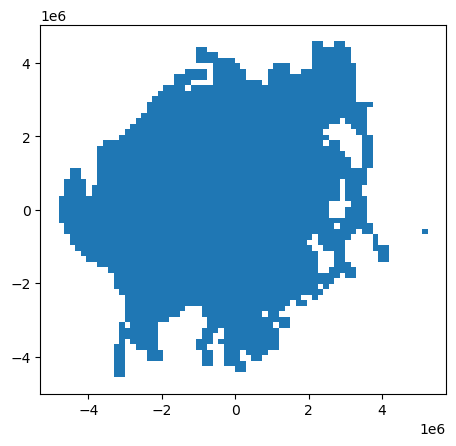

In [21]:
gdf_mb.plot(aspect='equal')


ValueError: aspect must be finite and positive 

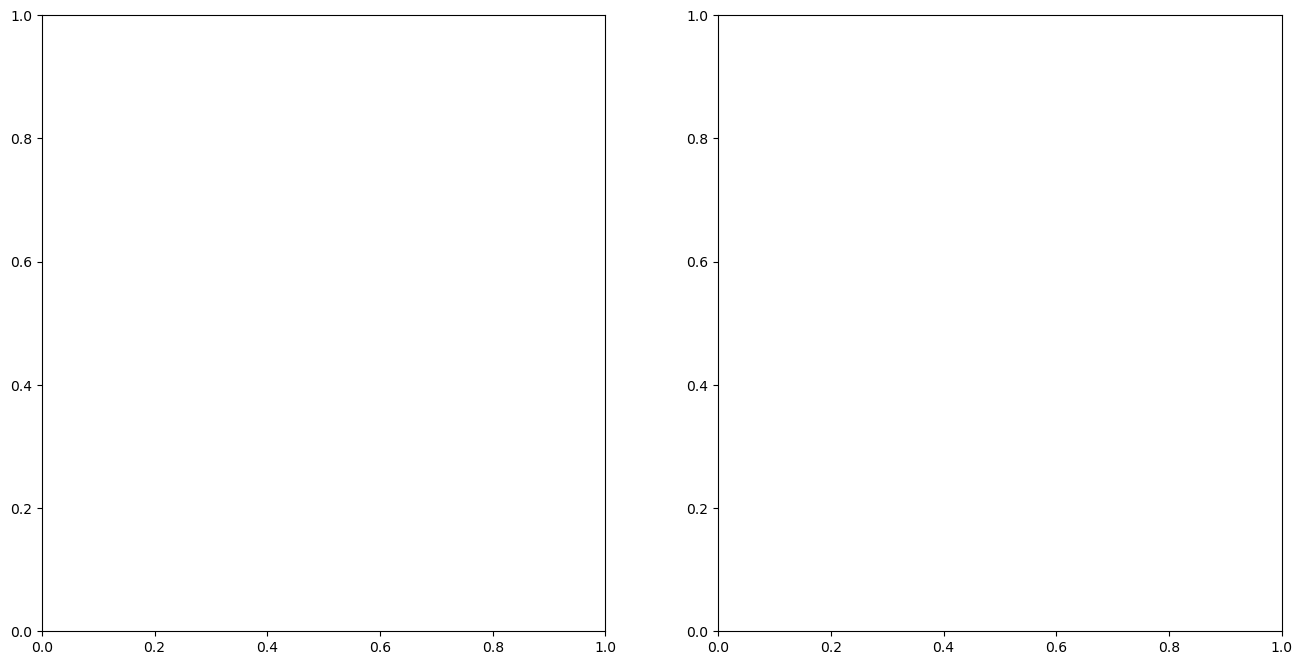

In [24]:
import matplotlib.pyplot as plt

# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ========== 左图：原始 EPSG:4326 坐标系 ==========
ax1 = axes[0]

# 绘制原始 tiles (EPSG:4326)
gdf.plot(ax=ax1, facecolor='none', edgecolor='blue', linewidth=0.5, alpha=0.5, label='GLANCE tiles (EPSG:4326)')

# MapBiomas 边界 (需要转到 EPSG:4326)
from shapely.geometry import box
mb_bounds_box = box(minx, miny, maxx, maxy)  # 这个 bounds 已经是 EPSG:4674
# 转换 MapBiomas 边界到 EPSG:4326
mb_gdf = gpd.GeoDataFrame([1], geometry=[mb_bounds_box], crs=mb_crs)
mb_gdf_4326 = mb_gdf.to_crs('EPSG:4326')
mb_gdf_4326.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2, label='MapBiomas extent')

ax1.set_title('Original CRS (EPSG:4326)', fontsize=14)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()
ax1.axis('equal')  # 使用 axis 而不是 set_aspect

# ========== 右图：投影后 EPSG:4674 坐标系 ==========
ax2 = axes[1]

# 绘制投影后的 tiles (EPSG:4674)
gdf_mb.plot(ax=ax2, facecolor='none', edgecolor='blue', linewidth=0.5, alpha=0.5, label='GLANCE tiles (EPSG:4674)')

# MapBiomas 边界 (原始坐标)
mb_gdf.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2, label='MapBiomas extent')

# 高亮相交的 tiles
gsel.plot(ax=ax2, facecolor='yellow', edgecolor='green', linewidth=1, alpha=0.3, label=f'Intersecting tiles ({len(gsel)})')

ax2.set_title('Reprojected CRS (EPSG:4674)', fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.axis('equal')  # 使用 axis 而不是 set_aspect

plt.tight_layout()
plt.show()

# ========== 打印统计信息 ==========
print("\n=== 投影前后坐标对比 ===")
print(f"原始 tiles CRS: {gdf.crs}")
print(f"原始 tiles bounds: {gdf.total_bounds}")
print(f"\n投影后 tiles CRS: {gdf_mb.crs}")
print(f"投影后 tiles bounds: {gdf_mb.total_bounds}")
print(f"\nMapBiomas CRS: {mb_crs}")
print(f"MapBiomas bounds: {mb_bounds}")
print(f"\n相交 tiles 数量: {len(gsel)} / {len(gdf)}")

# ========== 检查坐标有效性 ==========
print("\n=== 坐标有效性检查 ===")
print(f"gdf_mb 是否为空: {gdf_mb.empty}")
print(f"gsel 是否为空: {gsel.empty}")
print(f"mb_gdf 几何体: {mb_gdf.geometry.values}")


In [ ]:
# 诊断坐标系统问题
print("=== 坐标系统诊断 ===")
print(f"\nMapBiomas:")
print(f"  CRS: {mb_crs}")
print(f"  Bounds: {mb_bounds}")
print(f"  单位: 度 (经纬度)")

print(f"\nGLANCE tiles (原始):")
print(f"  CRS: {gdf.crs}")
print(f"  Bounds: {gdf.total_bounds}")

print(f"\nGLANCE tiles (投影后):")
print(f"  CRS: {gdf_mb.crs}")
print(f"  Bounds: {gdf_mb.total_bounds}")

# 检查 CRS 是否为地理坐标系 vs 投影坐标系
from pyproj import CRS as ProjCRS

mb_crs_obj = ProjCRS.from_user_input(mb_crs)
gdf_crs_obj = ProjCRS.from_user_input(gdf.crs)

print(f"\n=== CRS 类型 ===")
print(f"MapBiomas 是地理坐标系: {mb_crs_obj.is_geographic}")
print(f"MapBiomas 是投影坐标系: {mb_crs_obj.is_projected}")
print(f"GLANCE 是地理坐标系: {gdf_crs_obj.is_geographic}")
print(f"GLANCE 是投影坐标系: {gdf_crs_obj.is_projected}")

print(f"\n=== 单位 ===")
print(f"MapBiomas 单位: {mb_crs_obj.axis_info[0].unit_name}")
print(f"GLANCE 单位: {gdf_crs_obj.axis_info[0].unit_name}")


=== 坐标系统诊断 ===

MapBiomas:
  CRS: EPSG:4674
  Bounds: (-73.98318216, -16.661979170000002, -43.399292159999995, 5.26958083)
  单位: 度 (经纬度)

GLANCE tiles (原始):
  CRS: EPSG:4326
  Bounds: [-4805840. -4559265.  5244160.  4590735.]

GLANCE tiles (投影后):
  CRS: EPSG:4674
  Bounds: [-4805840. -4559265.  5244160.  4590735.]

=== CRS 类型 ===
MapBiomas 是地理坐标系: True
MapBiomas 是投影坐标系: False
GLANCE 是地理坐标系: True
GLANCE 是投影坐标系: False

=== 单位 ===
MapBiomas 单位: degree
GLANCE 单位: degree



=== 方案1: GLANCE → MapBiomas CRS ===
GLANCE 投影后 CRS: GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
GLANCE 投影后 bounds: [-4805840. -4559265.  5244160.  4590735.]

✓ 相交的 tiles: 1 / 2153


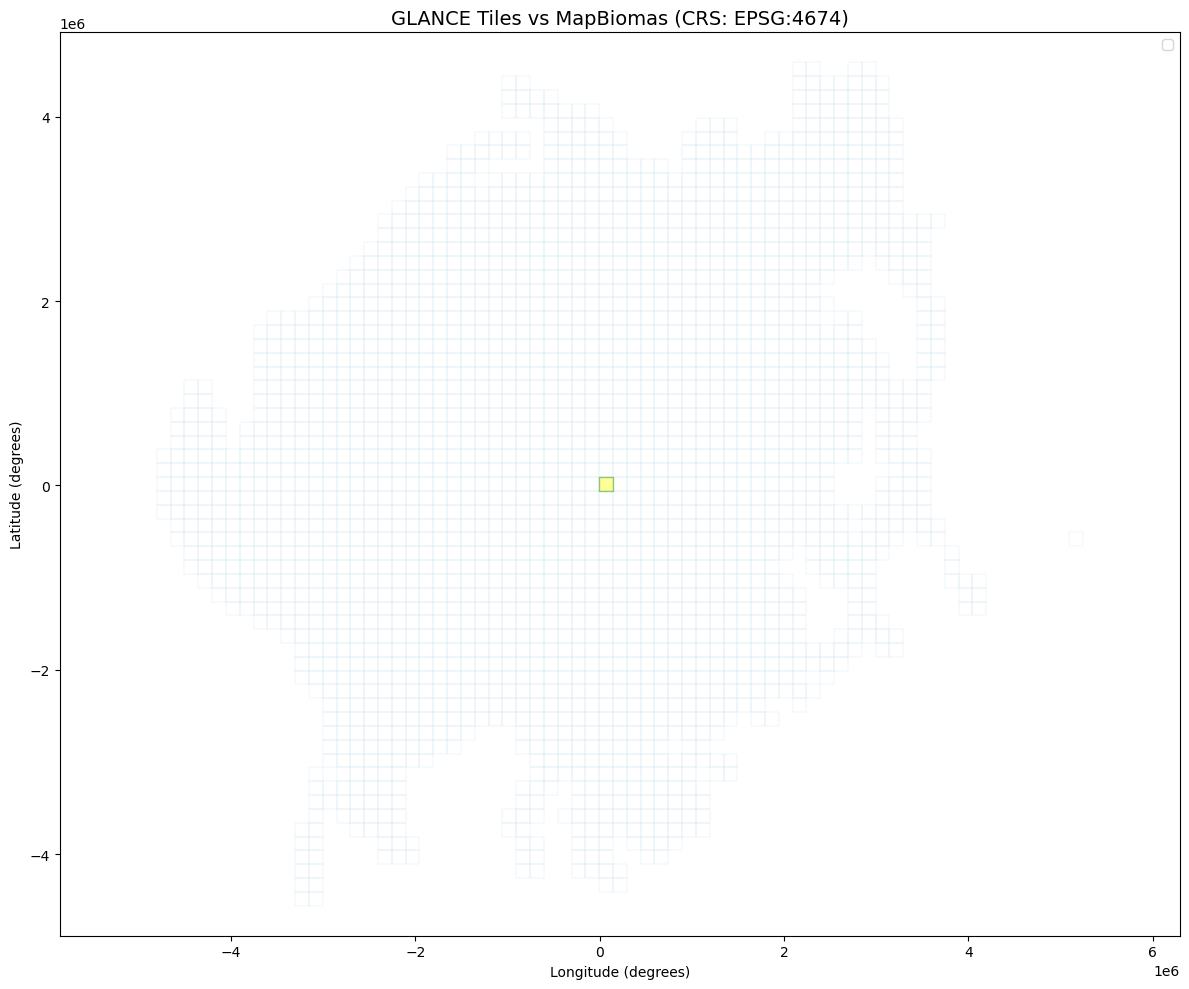


相交 tiles 的 tileID:
['h32v34']


In [33]:
# 正确的做法：确保两者在同一坐标系下比较

# 方案1: 把 GLANCE tiles 投影到 MapBiomas 坐标系 (EPSG:4674)
print("\n=== 方案1: GLANCE → MapBiomas CRS ===")
gdf_to_mb = gdf.to_crs(mb_crs)
print(f"GLANCE 投影后 CRS: {gdf_to_mb.crs}")
print(f"GLANCE 投影后 bounds: {gdf_to_mb.total_bounds}")

# 现在可以正确相交了
from shapely.geometry import box
mb_bbox = box(*mb_bounds)
gsel_correct = gdf_to_mb[gdf_to_mb.intersects(mb_bbox)]
print(f"\n✓ 相交的 tiles: {len(gsel_correct)} / {len(gdf)}")

# 可视化验证
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 10))

# 所有 GLANCE tiles (投影到 EPSG:4674)
gdf_to_mb.plot(ax=ax, facecolor='none', edgecolor='lightblue', linewidth=0.3, alpha=0.5, label='All GLANCE tiles', aspect='equal')

# MapBiomas 边界
mb_gdf = gpd.GeoDataFrame([1], geometry=[mb_bbox], crs=mb_crs)
mb_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='MapBiomas extent', aspect='equal')

# 相交的 tiles
gsel_correct.plot(ax=ax, facecolor='yellow', edgecolor='green', linewidth=1, alpha=0.4, label=f'Intersecting tiles ({len(gsel_correct)})', aspect='equal')

ax.set_title(f'GLANCE Tiles vs MapBiomas (CRS: {mb_crs})', fontsize=14)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.legend()
ax.axis('equal')
plt.tight_layout()
plt.show()

print(f"\n相交 tiles 的 tileID:")
print(gsel_correct['tileID'].tolist())


In [35]:
# 使用正确的 GLANCE CRS - Lambert Azimuthal Equal Area
print("=== 修正 GLANCE tiles CRS ===")

from pyproj import CRS as ProjCRS

# BU MEaSUREs Lambert Azimuthal Equal Area - SA - V01
glance_wkt = """PROJCS["BU MEaSUREs Lambert Azimuthal Equal Area - SA - V01",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["longitude_of_center",-60],PARAMETER["latitude_of_center",-15],UNIT["meter",1.0]]
"""

# 重新设置 CRS（不做投影，只是修正元数据）
gdf_corrected = gdf.copy()
gdf_corrected.crs = glance_wkt

print(f"原始 CRS (错误): {gdf.crs}")
print(f"修正后 CRS: {gdf_corrected.crs}")
print(f"修正后 bounds: {gdf_corrected.total_bounds}")

# 现在投影到 MapBiomas CRS (EPSG:4674)
gdf_to_mb_corrected = gdf_corrected.to_crs(mb_crs)
print(f"\n投影到 EPSG:4674 后:")
print(f"  CRS: {gdf_to_mb_corrected.crs}")
print(f"  Bounds: {gdf_to_mb_corrected.total_bounds}")

# 现在可以正确相交了
from shapely.geometry import box
mb_bbox = box(*mb_bounds)
gsel_final = gdf_to_mb_corrected[gdf_to_mb_corrected.intersects(mb_bbox)]
print(f"\n✓ 相交的 tiles: {len(gsel_final)} / {len(gdf)}")

if not gsel_final.empty:
    print(f"\n相交 tiles 的 tileID:")
    print(gsel_final['tileID'].tolist()[:20])  # 只显示前20个
    if len(gsel_final) > 20:
        print(f"... 还有 {len(gsel_final) - 20} 个")


=== 修正 GLANCE tiles CRS ===
原始 CRS (错误): EPSG:4326
修正后 CRS: PROJCS["BU MEaSUREs Lambert Azimuthal Equal Area - SA - V01",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["longitude_of_center",-60],PARAMETER["latitude_of_center",-15],UNIT["meter",1.0]]

修正后 bounds: [-4805840. -4559265.  5244160.  4590735.]

投影到 EPSG:4674 后:
  CRS: GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
  Bounds: [-107.71249136  -55.59056149   -9.18855025   27.93509468]

✓ 相交的 tiles: 412 / 2153

相交 tiles 的 tileID:
['h21v19', 'h22v19', 'h23v19', 

In [37]:
# 读取一张 GLANCE 影像并检查其 CRS
import glob
import rasterio

# 找到 2016 年的 GLANCE 文件
glance_pattern = "/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A2016*.SA.LC.tif"
glance_files = glob.glob(glance_pattern)

if glance_files:
    sample_file = glance_files[0]
    print(f"检查文件: {sample_file}")
    print(f"文件名: {os.path.basename(sample_file)}")
    
    with rasterio.open(sample_file) as src:
        print(f"\n=== GLANCE 影像 CRS 信息 ===")
        print(f"CRS: {src.crs}")
        print(f"CRS EPSG: {src.crs.to_epsg()}")
        print(f"\nCRS WKT:")
        print(src.crs.to_wkt())
        
        print(f"\n=== 影像空间信息 ===")
        print(f"Bounds: {src.bounds}")
        print(f"Shape: {src.shape}")
        print(f"Transform:\n{src.transform}")
        print(f"Resolution: {src.res}")
        
        # 检查是否为投影坐标系
        from pyproj import CRS as ProjCRS
        crs_obj = ProjCRS.from_user_input(src.crs)
        print(f"\n=== CRS 类型 ===")
        print(f"是地理坐标系: {crs_obj.is_geographic}")
        print(f"是投影坐标系: {crs_obj.is_projected}")
        if crs_obj.is_projected:
            print(f"单位: {crs_obj.axis_info[0].unit_name}")
else:
    print(f"未找到 GLANCE 文件，路径: {glance_pattern}")
    print("\n尝试列出目录内容:")
    dir_path = "/projectnb/measures/products/SA/v001/DAAC/LC/"
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)[:10]  # 只显示前10个
        print(f"目录中的文件示例: {files}")


检查文件: /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h58v36.001.20240214.SA.LC.tif
文件名: GLANCE.A20160701.h58v36.001.20240214.SA.LC.tif

=== GLANCE 影像 CRS 信息 ===
CRS: EPSG:10603
CRS EPSG: 10603

CRS WKT:
PROJCS["BU MEaSUREs Lambert Azimuthal Equal Area - SA - V01",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",-15],PARAMETER["longitude_of_center",-60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

=== 影像空间信息 ===
Bounds: BoundingBox(left=1781230.0, bottom=-650295.0, right=1931230.0, top=-500295.0)
Shape: (5000, 5000)
Transform:
| 30.00, 0.00, 1781230.00|
| 0.00,-30.00,-500295.00|
| 0.00, 0.00, 1.00|
Resolution: (30.0, 30.0)

=== CRS 类型 ===
是地理坐标系

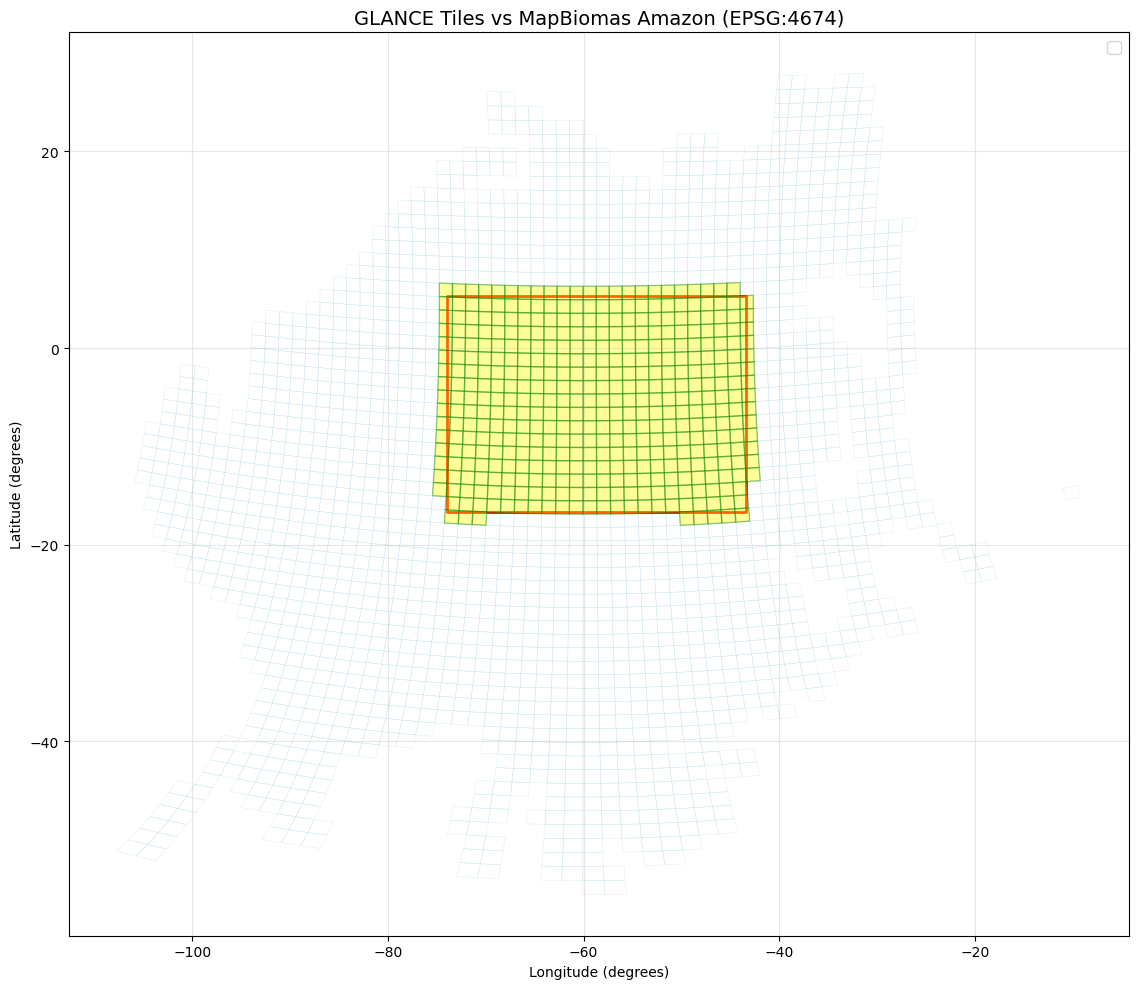


=== 最终统计 ===
总 GLANCE tiles: 2153
相交 tiles: 412
覆盖率: 19.1%


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 10))

# 所有 GLANCE tiles (修正并投影后)
gdf_to_mb_corrected.plot(ax=ax, facecolor='none', edgecolor='lightblue', 
                         linewidth=0.3, alpha=0.5, label='All GLANCE tiles')

# MapBiomas 边界
mb_gdf = gpd.GeoDataFrame([1], geometry=[mb_bbox], crs=mb_crs)
mb_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, 
            label='MapBiomas extent (Amazon)')

# 相交的 tiles
if not gsel_final.empty:
    gsel_final.plot(ax=ax, facecolor='yellow', edgecolor='green', 
                   linewidth=1, alpha=0.4, 
                   label=f'Intersecting tiles ({len(gsel_final)})')

ax.set_title(f'GLANCE Tiles vs MapBiomas Amazon (EPSG:4674)', fontsize=14)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 打印详细统计
print("\n=== 最终统计 ===")
print(f"总 GLANCE tiles: {len(gdf)}")
print(f"相交 tiles: {len(gsel_final)}")
print(f"覆盖率: {len(gsel_final)/len(gdf)*100:.1f}%")


In [43]:
import os
import glob
import re

# 假设 gsel_final 已经定义（从之前的代码中）
# gsel_final = ...  # 你的相交 tiles GeoDataFrame

# 获取 tileID 列表（假设 tileID 是 h*v* 格式，如 'h09v07'）
tile_ids = set(gsel_final["tileID"].astype(str))
print(f"Total intersecting tiles: {len(tile_ids)}")

# GLANCE 文件基础路径
folder_glance = "/projectnb/measures/products/SA/v001/DAAC/LC/"
year = 2016
region = "SA"

# Match files by tile ID
pattern = os.path.join(folder_glance, f"GLANCE.A{year}0701.h*v*.001.*.{region}.LC.tif")
all_files = sorted(glob.glob(pattern))

selected = [
    f for f in all_files 
    if (m := re.search(r'h\d+v\d+', os.path.basename(f))) 
    and m.group(0) in tile_ids
]

existing_files = selected

# 提取存在的 tile IDs
existing_tile_ids = set()
for f in existing_files:
    m = re.search(r'h\d+v\d+', os.path.basename(f))
    if m:
        existing_tile_ids.add(m.group(0))

missing_files = tile_ids - existing_tile_ids

print(f"\nExisting GLANCE files: {len(existing_files)}")
print(f"Missing GLANCE files: {len(missing_files)}")

if missing_files:
    print(f"\nMissing tileIDs: {list(missing_files)[:10]}")  # 显示前10个缺失的
    if len(missing_files) > 10:
        print(f"... and {len(missing_files) - 10} more")

# 如果需要，也可以列出存在的文件
if existing_files:
    print(f"\nSample existing files:")
    for f in existing_files[:5]:  # 显示前5个
        print(f"  {os.path.basename(f)}")
    if len(existing_files) > 5:
        print(f"  ... and {len(existing_files) - 5} more")


Total intersecting tiles: 412

Existing GLANCE files: 235
Missing GLANCE files: 177

Missing tileIDs: ['h28v21', 'h22v19', 'h23v35', 'h28v19', 'h22v24', 'h28v23', 'h27v19', 'h21v34', 'h33v34', 'h31v30']
... and 167 more

Sample existing files:
  GLANCE.A20160701.h22v21.001.20240219.SA.LC.tif
  GLANCE.A20160701.h22v22.001.20240219.SA.LC.tif
  GLANCE.A20160701.h22v23.001.20240219.SA.LC.tif
  GLANCE.A20160701.h23v22.001.20240219.SA.LC.tif
  GLANCE.A20160701.h23v23.001.20240219.SA.LC.tif
  ... and 230 more


In [1]:
import os
import glob

# Assuming these are defined (from your existing code)
folder_glance = "/projectnb/measures/products/SA/v001/DAAC/LC/"
year = 2016
region = "SA"

# Construct the pattern
pattern = os.path.join(folder_glance, f"GLANCE.A{year}0701.h*v*.001.*.{region}.LC.tif")

# Get the list of matching files
matching_files = sorted(glob.glob(pattern))

# Print the results
print(f"Found {len(matching_files)} matching files:")
if matching_files:
    for f in matching_files[:10]:  # Show first 10 for brevity
        print(f"  {f}")
    if len(matching_files) > 10:
        print(f"  ... and {len(matching_files) - 10} more")
else:
    print("No files found matching the pattern.")


Found 1012 matching files:
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h14v45.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h14v46.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h16v44.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h16v45.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h17v44.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h17v45.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h22v21.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h22v22.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h22v23.001.20240219.SA.LC.tif
  /projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h23v22.001.20240219.SA.LC.tif
  ... and 1002 more


In [ ]:
matching_files


['/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h14v45.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h14v46.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h16v44.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h16v45.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h17v44.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h17v45.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h22v21.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h22v22.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h22v23.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20160701.h23v22.001.20240219.SA.LC.tif',
 '/projectnb/measures/products/SA/v001/D

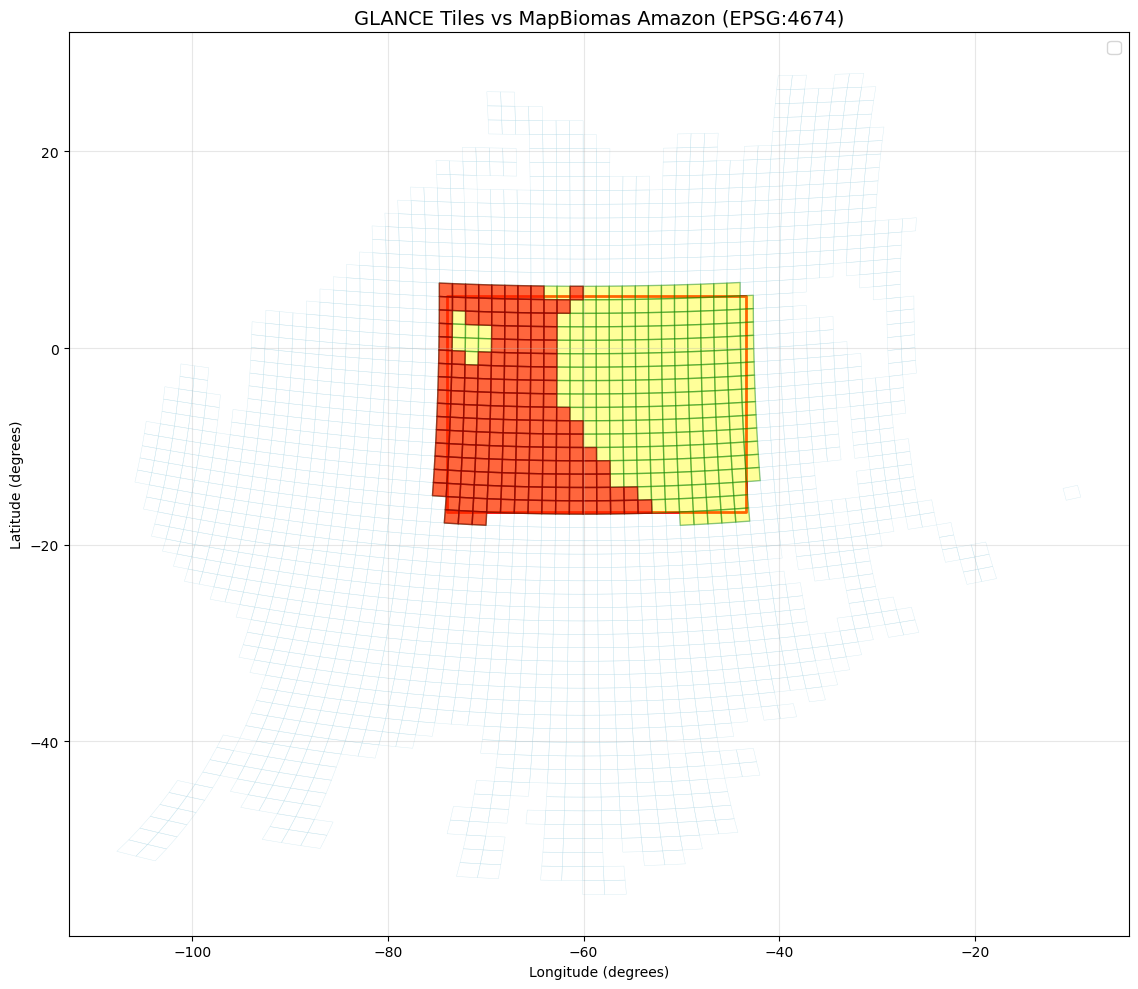


=== 最终统计 ===
总 GLANCE tiles: 2153
相交 tiles: 412
覆盖率: 19.1%
有 GLANCE 文件的相交 tiles: 235
缺失 GLANCE 文件的相交 tiles: 177


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 10))

# 所有 GLANCE tiles (修正并投影后)
gdf_to_mb_corrected.plot(ax=ax, facecolor='none', edgecolor='lightblue', 
                         linewidth=0.3, alpha=0.5, label='All GLANCE tiles')

# MapBiomas 边界
mb_gdf = gpd.GeoDataFrame([1], geometry=[mb_bbox], crs=mb_crs)
mb_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, 
            label='MapBiomas extent (Amazon)')

# 相交的 tiles
if not gsel_final.empty:
    gsel_final.plot(ax=ax, facecolor='yellow', edgecolor='green', 
                   linewidth=1, alpha=0.4, 
                   label=f'Intersecting tiles ({len(gsel_final)})')

# Missing tiles (no GLANCE file)
missing_gdf = gsel_final[gsel_final['tileID'].isin(missing_files)]
if not missing_gdf.empty:
    missing_gdf.plot(ax=ax, facecolor='red', edgecolor='darkred', 
                     linewidth=1, alpha=0.6, 
                     label=f'Missing GLANCE files ({len(missing_gdf)})')

ax.set_title(f'GLANCE Tiles vs MapBiomas Amazon (EPSG:4674)', fontsize=14)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 打印详细统计
print("\n=== 最终统计 ===")
print(f"总 GLANCE tiles: {len(gdf)}")
print(f"相交 tiles: {len(gsel_final)}")
print(f"覆盖率: {len(gsel_final)/len(gdf)*100:.1f}%")
print(f"有 GLANCE 文件的相交 tiles: {len(existing_files)}")
print(f"缺失 GLANCE 文件的相交 tiles: {len(missing_files)}")


In [ ]:
import rasterio
import numpy as np

tif_mb = "/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/AMZ.2016.M.tif"

with rasterio.open(tif_mb) as src:
    # 文件信息
    print(f"文件大小: {os.path.getsize(tif_mb) / 1e9:.2f} GB")
    print(f"数据形状: {src.shape}")
    print(f"数据类型: {src.dtypes[0]}")
    print(f"压缩方式: {src.compression}")
    
    # 计算未压缩大小
    raw_size = src.height * src.width * np.dtype(src.dtypes[0]).itemsize
    print(f"未压缩大小: {raw_size / 1e9:.2f} GB")
    
    # 压缩比
    file_size = os.path.getsize(tif_mb)
    print(f"压缩比: {raw_size / file_size:.1f}:1")
    
    # 读取一个小块测试数据分布
    sample = src.read(1, window=((0, 1000), (0, 1000)))
    unique_vals = np.unique(sample)
    print(f"样本唯一值: {len(unique_vals)} 个类别")
    print(f"类别分布: {np.bincount(sample.ravel())}")


文件大小: 1.05 GB
数据形状: (243684, 339821)
数据类型: uint8
压缩方式: Compression.lzw
未压缩大小: 82.81 GB
压缩比: 78.9:1
样本唯一值: 1 个类别
类别分布: [1000000]


In [ ]:
from odc.geo.xr import xr_reproject


In [ ]:
# select_tiles.py
import os, glob, re
import geopandas as gpd
import rioxarray
from shapely.geometry import box

YEAR = 2016
MAPBIOMAS_TIF = "/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/AMZ.2016.M.tif"
GLANCE_DIR = "/projectnb/measures/products/SA/v001/DAAC/LC"
GEOJSON = "/projectnb/measures/datasets/Grids/FILTERED/json/GLANCE_V01_AS_PROJ_TILE_FILTERED.geojson"
OUTLIST = "/projectnb/modislc/users/chishan/data/forest_comparison_2016/tiles.txt"
os.makedirs(os.path.dirname(OUTLIST), exist_ok=True)

# load mapbiomas template
mb = rioxarray.open_rasterio(MAPBIOMAS_TIF, chunks={"x":1,"y":1}).squeeze("band", drop=True)
mb_bounds = mb.rio.bounds(); mb_crs = mb.rio.crs

gdf = gpd.read_file(GEOJSON)

# 如果 geojson 没有 crs 或标错（坐标量级像米），用一个 sample GLANCE 的 crs 覆盖
sample = sorted(glob.glob(os.path.join(GLANCE_DIR, f"GLANCE.A{YEAR}0701.h*v*.001.*.SA.LC.tif")))[0]
import rasterio
with rasterio.open(sample) as ds:
    glance_crs = ds.crs
if gdf.crs is None or (gdf.crs.is_geographic and max(abs(gdf.total_bounds))>1000):
    gdf = gdf.set_crs(glance_crs, allow_override=True)

gdf_mb = gdf.to_crs(mb_crs)
minx, miny, maxx, maxy = mb_bounds
mb_box = box(minx, miny, maxx, maxy)
sel = gdf_mb[gdf_mb.intersects(mb_box)]
tile_ids = set(sel["tileID"].astype(str).tolist())

pattern = os.path.join(GLANCE_DIR, f"GLANCE.A{YEAR}0701.h*v*.001.*.SA.LC.tif")
allf = sorted(glob.glob(pattern))
selected = [os.path.abspath(f) for f in allf if (m:=re.search(r'h\d+v\d+', os.path.basename(f))) and m.group(0) in tile_ids]

with open(OUTLIST, "w") as fh:
    fh.write("\n".join(selected))
print("Selected tiles:", len(selected), "written to", OUTLIST)


In [ ]:
import ee
ee.Initialize()

GLANCE_V001 = ee.ImageCollection("projects/GLANCE/DATASETS/V001")
CODF_polygons = ee.FeatureCollection("projects/ee-zcs/assets/CODF_polygons")

filtered_CODF_polygons = CODF_polygons

buffers = [10000, 25000]  # meters

# Create buffers with additional metadata
def create_buffer(dist):
    def buffer_feature(f):
        return (f.buffer(dist)
                .set('buffer_dist', dist)
                .set('buffer_km', dist/1000)
                .set('original_id', f.get('BU ID')))
    
    return filtered_CODF_polygons.map(buffer_feature)

bufferFCs = [create_buffer(dist) for dist in buffers]

mapDates = [
    '2001-07-01', '2002-07-01', '2003-07-01', '2004-07-01', '2005-07-01',
    '2006-07-01', '2007-07-01', '2008-07-01', '2009-07-01', '2010-07-01',
    '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01', '2015-07-01',
    '2016-07-01', '2017-07-01', '2018-07-01', '2019-07-01'
]

_mapDates = ee.List(mapDates)

# Create land cover stack
def create_lc_image(d):
    return (GLANCE_V001
            .filter(ee.Filter.stringStartsWith('system:index', ee.String(d)))
            .select('LC')
            .mosaic()
            .set('date', d))

GLOBAL = {}
GLOBAL['LCstack'] = (ee.ImageCollection(_mapDates.map(create_lc_image))
                     .toBands()
                     .rename(_mapDates))

# Analysis parameters
fromYear = '2009-07-01'
toYear = '2019-07-01'
forestCode = 5  # Forest class code
